# 📘 News Classification with XGBoost and Neural Networks

This notebook walks through the **AG News dataset** classification task using:
- **TF-IDF + XGBoost**
- **Neural Networks with Keras**

We will cover the following steps:

1. Setup, Data Loading, and Initial Preprocessing  
2. Text Preprocessing  
3. Feature Engineering with TF-IDF  
4. Model Training with XGBoost  
5. Visualization of Word Frequencies  
6. Neural Network Model with Keras  


## 🔧 Step 1: Setup, Data Loading, and Initial Preprocessing
We start by installing and importing the necessary libraries, followed by loading the dataset.  
Make sure you have the **AG News dataset (`train.csv`)** in the same directory.


In [23]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout


### Download necessary NLTK data
Uncomment these lines if you face errors related to **stopwords** or **lemmatization**.


In [24]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')


### Load the dataset
Each row contains:
- `class` (1–4 → World, Sports, Business, Sci/Tech)  
- `title`  
- `description`

We will combine **title + description** into a single text field.


In [25]:
try:
    df = pd.read_csv('train.csv', header=None, names=['class', 'title', 'description'])
except FileNotFoundError:
    print("Error: 'train.csv' not found. Please download the AG News dataset from Kaggle.")
    exit()

df['text'] = df['title'] + ' ' + df['description']
print("Data loaded and combined successfully.")
df.head()


Data loaded and combined successfully.


,class,title,description,text
0,Class Index,Title,Description,Title Description
1,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
2,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
3,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
4,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...


## 📝 Step 2: Text Preprocessing
We will clean and preprocess the text by:
1. Lowercasing  
2. Removing numbers and punctuation  
3. Removing stopwords  
4. Lemmatizing words  

This ensures the model focuses on meaningful words.


In [26]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)
df[['text', 'processed_text']].head()


,text,processed_text
0,Title Description,title description
1,Wall St. Bears Claw Back Into the Black (Reute...,wall st bear claw back black reuters reuters s...
2,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle look toward commercial aerospace reute...
3,Oil and Economy Cloud Stocks' Outlook (Reuters...,oil economy cloud stock outlook reuters reuter...
4,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halt oil export main southern pipeline re...


## 🔎 Step 3: Feature Engineering with TF-IDF
We now convert the processed text into **numerical vectors** using **TF-IDF**.  
This captures the importance of each word relative to the document and the dataset.


In [27]:
X = df['processed_text']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF vectorization complete.")


TF-IDF vectorization complete.


## 🚀 Step 4: Model Training with XGBoost
We train an **XGBoost Classifier** for multiclass classification using the TF-IDF features.


In [33]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# -------------------
# 1. Preprocessing function
# -------------------
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# -------------------
# 2. Create processed_text column
# -------------------
df['processed_text'] = (df['title'].astype(str) + " " + df['description'].astype(str)).apply(preprocess_text)

# -------------------
# 3. Features (X) and Labels (y)
# -------------------
X = df['processed_text']
y = df['class'].astype(int) - 1   # adjust classes to start at 0

# -------------------
# 4. Train/Test split
# -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------
# 5. Vectorization (TF-IDF)
# -------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# -------------------
# 6. XGBoost Classifier
# -------------------
model = XGBClassifier(
    objective='multi:softmax', 
    num_class=len(y.unique()), 
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

model.fit(X_train_vec, y_train)

# -------------------
# 7. Evaluation
# -------------------
y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


D:\jupyter_lab\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:20:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8869166666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      6000
           1       0.92      0.96      0.94      6000
           2       0.86      0.86      0.86      6000
           3       0.85      0.85      0.85      6000

    accuracy                           0.89     24000
   macro avg       0.89      0.89      0.89     24000
weighted avg       0.89      0.89      0.89     24000



## 📊 Step 5: Visualization of Word Frequencies
Let’s visualize the **most frequent words** for each category.  
Example: Category **1 = World News**


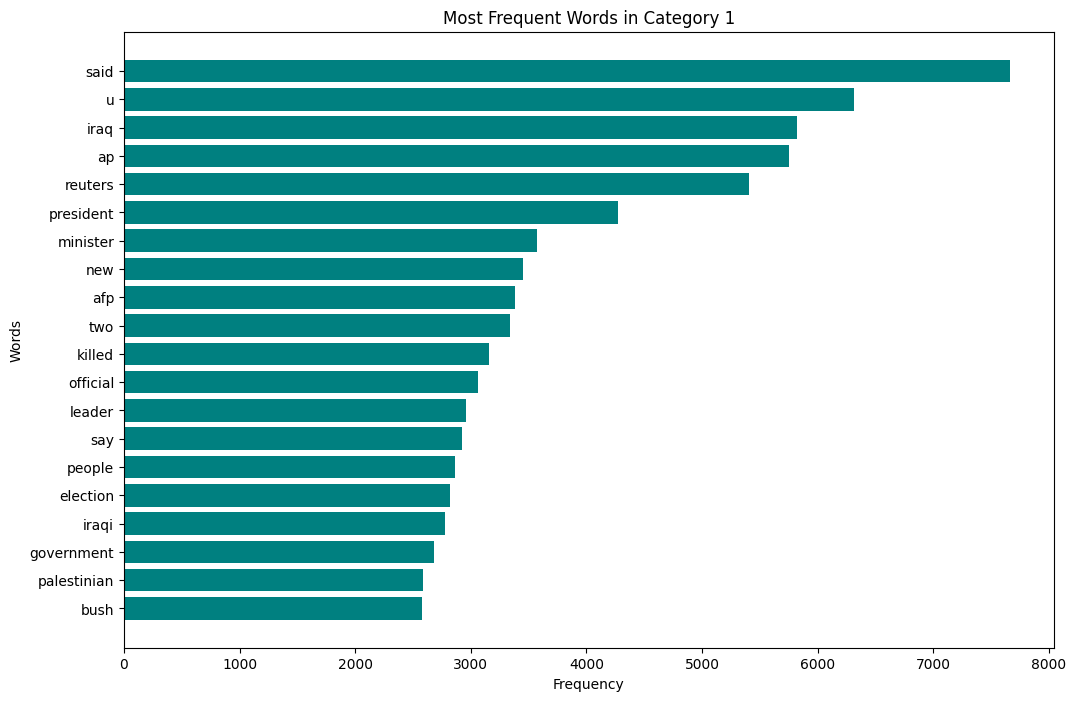

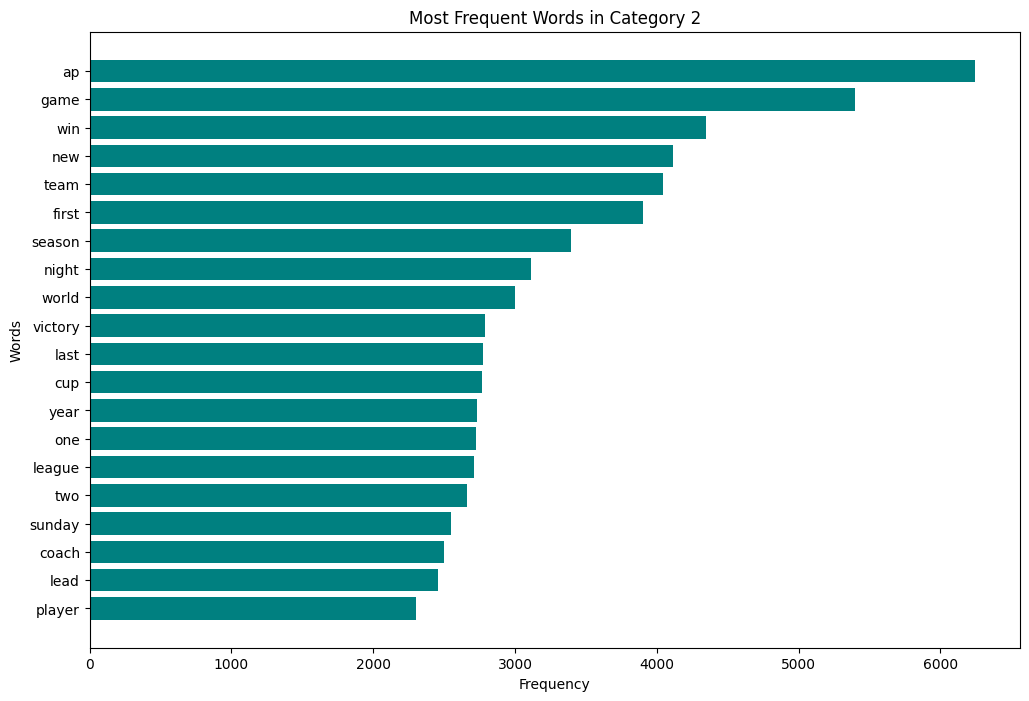

In [34]:
def visualize_top_words(category_class, top_n=20):
    category_texts = df[df['class'] == category_class]['processed_text']
    all_words = ' '.join(category_texts).split()
    
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(top_n)
    
    words, counts = zip(*most_common_words)
    
    plt.figure(figsize=(12, 8))
    plt.barh(words, counts, color='teal')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Most Frequent Words in Category {category_class}')
    plt.gca().invert_yaxis()
    plt.show()

visualize_top_words(1)
visualize_top_words(2)


## 🤖 Step 6: Neural Network with Keras
We now try a **Neural Network approach** as an alternative to XGBoost.  
Instead of TF-IDF, we use **Keras Tokenizer + Embedding Layer** to learn word representations.


In [35]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
oov_token = "<oov>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

y_train_nn = tf.keras.utils.to_categorical(y_train - 1, num_classes=4)
y_test_nn = tf.keras.utils.to_categorical(y_test - 1, num_classes=4)


### Build and Train the Neural Network
We use a simple architecture with:
- Embedding layer  
- Dense + Dropout  
- Softmax output for classification


In [36]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

print("\nTraining the Neural Network...")
history = model.fit(train_padded, y_train_nn, epochs=10, 
                    validation_data=(test_padded, y_test_nn), verbose=2)

loss, accuracy = model.evaluate(test_padded, y_test_nn, verbose=0)
print(f"\nNeural Network Accuracy on Test Data: {accuracy:.4f}")


D:\jupyter_lab\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training the Neural Network...
Epoch 1/10
3000/3000 - 28s - 9ms/step - accuracy: 0.8614 - loss: 0.3963 - val_accuracy: 0.9152 - val_loss: 0.2527
Epoch 2/10
3000/3000 - 24s - 8ms/step - accuracy: 0.9252 - loss: 0.2315 - val_accuracy: 0.9168 - val_loss: 0.2544
Epoch 3/10
3000/3000 - 39s - 13ms/step - accuracy: 0.9389 - loss: 0.1815 - val_accuracy: 0.9139 - val_loss: 0.2729
Epoch 4/10
3000/3000 - 40s - 13ms/step - accuracy: 0.9549 - loss: 0.1301 - val_accuracy: 0.9071 - val_loss: 0.3146
Epoch 5/10
3000/3000 - 41s - 14ms/step - accuracy: 0.9711 - loss: 0.0840 - val_accuracy: 0.9029 - val_loss: 0.4076
Epoch 6/10
3000/3000 - 35s - 12ms/step - accuracy: 0.9802 - loss: 0.0552 - val_accuracy: 0.8975 - val_loss: 0.4741
Epoch 7/10
3000/3000 - 24s - 8ms/step - accuracy: 0.9864 - loss: 0.0391 - val_accuracy: 0.8958 - val_loss: 0.6026
Epoch 8/10
3000/3000 - 26s - 9ms/step - accuracy: 0.9900 - loss: 0.0302 - val_accuracy: 0.8922 - val_loss: 0.7051
Epoch 9/10
3000/3000 - 24s - 8ms/step - accuracy: 0.